In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import csv
import os
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [2]:
training_data_df = pd.read_csv('/kaggle/input/sarcasm-glove/Sarcasm_training.csv')
training_data_df = training_data_df[['TEXT ', 'IS_SARCASTIC']]
training_data_df['IS_SARCASTIC'] = pd.to_numeric(training_data_df['IS_SARCASTIC'], errors='coerce')
train_data_df_cleaned = training_data_df[training_data_df['IS_SARCASTIC'].isin([0, 1])]
invalid_rows_after_cleanup = train_data_df_cleaned[~train_data_df_cleaned['IS_SARCASTIC'].isin([0, 1])]
invalid_rows_count_after_cleanup = len(invalid_rows_after_cleanup)
training_data_df = train_data_df_cleaned
training_data_df.rename(columns={"TEXT ": "TEXT"}, inplace=True)
# training_data_df
train_val_split_factor = 0.8

num_training_samples = int(len(training_data_df) * train_val_split_factor)

shuffled_indices = np.random.RandomState(seed=150).permutation(len(training_data_df))

train_indices = shuffled_indices[:num_training_samples]
val_indices = shuffled_indices[num_training_samples:]

train_data_df = training_data_df.iloc[train_indices].reset_index(drop=True)
val_df = training_data_df.iloc[val_indices].reset_index(drop=True)
len(train_data_df), len(val_df)

(20545, 5137)

In [3]:

def load_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index


local_embeddings_path = '/kaggle/input/sarcasm-glove/glove.6B.50d.txt'
word_vectors = load_embeddings(local_embeddings_path)

In [4]:
class SarcasmDataset(Dataset):
    def __init__(self, dataframe, word_vectors, max_length):
        self.data = dataframe
        self.word_vectors = word_vectors
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['TEXT']
        label = self.data.iloc[idx]['IS_SARCASTIC']
        vector = self.sentence_to_vector(text)
        return vector, label

    def sentence_to_vector(self, sentence):
        tokens = word_tokenize(sentence.lower())
        vector = np.zeros((self.max_length, 50))  # 50 is the embedding size
        for i, token in enumerate(tokens):
            if i >= self.max_length:
                break
            if token in self.word_vectors:
                vector[i] = self.word_vectors[token]
        return vector

In [5]:
max_length = 100

train_dataset = SarcasmDataset(train_data_df, word_vectors, max_length)
val_dataset = SarcasmDataset(val_df, word_vectors, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
class CNNModel(nn.Module):
    def __init__(self, embedding_dim, num_classes=1):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
#         return torch.sigmoid(x)
        return x


In [7]:
model = CNNModel(embedding_dim=50)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [8]:
def train_model(model,device,train_dataloader):
    model.train()
    total_predictions = 0
    correct_predictions = 0
    train_loss = 0
    for batch_idx, (inputs,labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
#         print(inputs.shape)
        outputs = model(inputs.float())
        loss = criterion(outputs.squeeze(), labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        output_probabilities = F.sigmoid(outputs)
        preds = (output_probabilities >= 0.5).float()
        correct_predictions += torch.sum(preds.squeeze(1)  == labels).item()
        total_predictions += labels.size(0)

    avg_train_loss = train_loss / len(train_dataloader)  
    train_accuracy = 100 * correct_predictions / total_predictions
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%')
    return avg_train_loss,train_accuracy


def validation_check(model,device,validation_dataloader):
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs,labels) in enumerate(validation_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()
            output_probabilities = F.sigmoid(outputs)
            preds = (output_probabilities >= 0.5).float()
            correct_val += torch.sum(preds.squeeze(1)  == labels).item()
            total_val += labels.size(0)
    avg_val_loss = val_loss / len(validation_dataloader)
    val_accuracy = 100 * correct_val / total_val
    # print(f'Validation Accuracy: {val_accuracy:.2f}%')
    return avg_val_loss,val_accuracy

In [9]:
model_save_path = 'model.pth' 
model_state_dict_path = 'model_state_dict.pth'
epochs = 8
training_losses = []
training_accs = []
val_losses = []
val_accs = []
start_time = time.time()
for epoch in range(epochs):
    loss, accuracy = train_model(model,device,train_loader)
    training_losses.append(loss)
    training_accs.append(accuracy)
    val_loss, val_acc = validation_check(model, device, val_loader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    e_time = (time.time() - start_time)/60
    print(f"epoch: {epoch+1}, train loss: {loss:.4f}, val. loss: {val_loss:.4f}, train acc: {accuracy:.4f}, val acc: {val_acc:.4f}, time: {e_time:.2f} mins")
    torch.save(model, model_save_path)
    torch.save(model.state_dict(), model_state_dict_path)
    epoch_nums = list(range(1, epoch+2))
    csv_file_path = "losses.csv"
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"])   
        for epoch, train_loss, validation_loss, tacc, vacc in zip(epoch_nums, training_losses, val_losses, training_accs, val_accs):
            writer.writerow([epoch, train_loss, validation_loss, tacc, vacc])

epoch: 1, train loss: 0.5598, val. loss: 0.4951, train acc: 70.8577, val acc: 78.1974, time: 0.60 mins
epoch: 2, train loss: 0.4097, val. loss: 0.3752, train acc: 81.9363, val acc: 83.1419, time: 1.20 mins
epoch: 3, train loss: 0.3540, val. loss: 0.3615, train acc: 84.7839, val acc: 84.0568, time: 1.80 mins
epoch: 4, train loss: 0.3199, val. loss: 0.3490, train acc: 86.6676, val acc: 84.0374, time: 2.40 mins
epoch: 5, train loss: 0.2969, val. loss: 0.3545, train acc: 87.7142, val acc: 84.7771, time: 3.01 mins
epoch: 6, train loss: 0.2717, val. loss: 0.3414, train acc: 88.7461, val acc: 85.1080, time: 3.61 mins
epoch: 7, train loss: 0.2506, val. loss: 0.3624, train acc: 89.9289, val acc: 84.6019, time: 4.22 mins
epoch: 8, train loss: 0.2276, val. loss: 0.3948, train acc: 91.0095, val acc: 83.7843, time: 4.82 mins


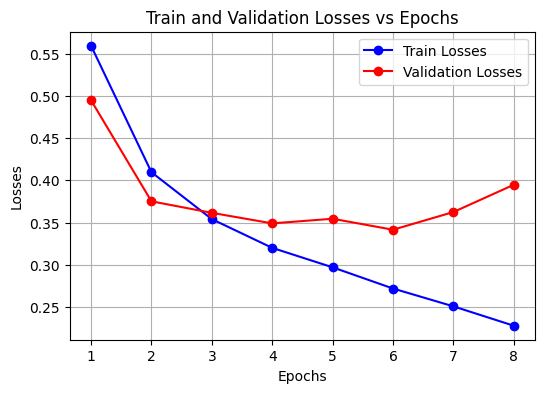

In [10]:
epoch_nums = list(range(1, epochs+1))
plt.figure(figsize=(6, 4))
plt.plot(epoch_nums, training_losses, '-o', color='b', label='Train Losses')
plt.plot(epoch_nums, val_losses, '-o', color='r', label='Validation Losses')

plt.title('Train and Validation Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid(True)
plt.legend()
plt.savefig('train_and_validation_losses.png')
plt.show()

In [11]:
test_data_df = pd.read_csv('/kaggle/input/sarcasm-test-new/test_data.csv')
test_data_df = test_data_df[['ID','text']]


def sentence_to_vector(sentence, word_vectors, max_length):
    tokens = word_tokenize(sentence.lower())
    vector = np.zeros((max_length, 50))
    for i, token in enumerate(tokens):
        if i >= max_length:
            break
        if token in word_vectors:
            vector[i] = word_vectors[token]
    return vector


def predict_sarcasm(sentence, word_vectors, model, device):
    model.eval() 
    with torch.no_grad(): 
        sentence_vector = sentence_to_vector(sentence, word_vectors, 100)
        sentence_vector = torch.tensor(sentence_vector).float().to(device)
        sentence_vector = sentence_vector.unsqueeze(0)  
        output = model(sentence_vector)
        output_probabilities = F.sigmoid(output)
        preds = (output_probabilities >= 0.5).float()
#         prediction = torch.sigmoid(output)
        return preds
    
    
all_preds = []
for index, row in test_data_df.iterrows():
    ID = row['ID']
    sentence = row['text']
    pred_tensor = predict_sarcasm(sentence,word_vectors, model, device) 
    pred = int(pred_tensor.cpu().numpy().flatten()[0])
    all_preds.append((ID, pred))

results_df = pd.DataFrame(all_preds, columns=['ID', 'IS_SARCASTIC'])
results_df.to_csv('predictions.csv', index=False) 